In [1]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# Notebook part 5: radial correlation
# First we load in the necessary modules:

# Standard libraries
import numpy as np;import scipy as sp;import matplotlib.pyplot as plt
import math;import warnings;import cv2
import matplotlib.ticker as tck

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Ellipse, Circle


# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft
from astropy.stats import kuiper

import FITS_tools
from operator import itemgetter

#plt.style.use('seaborn-deep')

# 3d plotting for mostly fun:
from mpl_toolkits import mplot3d
from skimage import io, transform 

# image reprojection:
from reproject import reproject_interp
import reproject

from matplotlib import rc

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm




In [2]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# x-ray image:

xray_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits"
xray_fits = fits.open(xray_path)

# smoothed x-ray image:

smooth_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits"
smooth_fits = fits.open(smooth_path)

# catalogue files:

# shape of short file: 12 X 1374
# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)

# shape of long file: 22 X 1301
# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)

# data tble for members is the following shape 11 x 50:
#ID	RA (Deg)	DEC (Deg)	Mag (140W)	Colour	Z	Membership	quality	Age (Gyr)	Tau	Mass (log10(M/Ms))

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# syntax to sort a list of lists :
#sorted_by_140W = sorted(member_data.T, key=itemgetter(3))

# individual arrays of data for member galaxies:
nat_ID = np.array(member_data[0], dtype=float);  nat_RA = np.array(member_data[1], dtype=float);
nat_DEC = np.array(member_data[2], dtype=float); nat_mag = np.array(member_data[3], dtype=float);
nat_col = np.array(member_data[4], dtype=float); nat_z = np.array(member_data[5], dtype=float);
nat_notes = np.array(member_data[6], dtype=str); nat_quality = np.array(member_data[7], dtype=str)
nat_age =  np.array(member_data[8], dtype=float);nat_tau = np.array(member_data[9], dtype=float)
nat_mass =  np.array(member_data[10], dtype=float)

In [3]:
colours2=['#006483', '#84001c', '#012256','#696479', '#810053', '#ff5b65']


In [4]:
data_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/member_data_extended.csv'
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T
mem_data_m26 = mem_data.T
mem_data_m26 = np.array([mem_data_m26[i] for i in range(len(mem_data_m26)) if ((np.isnan(mem_data_m26[i][13])==False))]).T
mem_data_m26 = np.nan_to_num(mem_data_m26);
red_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) >1.15]).T
blue_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) <=1.15]).T


old_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]>1.0]).T
young_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]<=1.0]).T



In [5]:
# now we want to create the faint red sample:
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'

pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

m_red, b_red = np.polyfit(red_m26[4], red_m26[13],1)


pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

faint_reds = np.array([pot_members.T[i] for i in range(len(pot_members.T)) if pot_members.T[i][25]==1]).T
                
faint_red_flux = faint_reds[23]; faint_red_mass = faint_reds[22]   
    
faint_reds_imp = [faint_reds[16], faint_reds[1], faint_reds[2], faint_reds[23], faint_reds[22]]    
    
    
all_red_mass = list(red_m26[13]) + list(faint_red_mass); all_red_flux = list(red_m26[21])+list(faint_red_flux)
all_red_RA = list(red_m26[1]) + list(faint_reds[1]); all_red_DEC = list(red_m26[2])+list(faint_reds[2])
all_red_ID = list(red_m26[0]) + list(faint_reds[16])

all_red_data = [all_red_ID, all_red_RA, all_red_DEC, all_red_mass, all_red_flux]


red_r, red_p =  sp.stats.pearsonr(10**np.array(all_red_mass), all_red_flux)

print(red_r,red_p)


0.49107131901247897 5.772787382791583e-06


In [6]:
# projections:
xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)    
extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)
xray_hdu = fits.open(xray_path)[0]
xray_wcs = WCS(xray_hdu.header)
xray_smooth_hdu = fits.open(smooth_path)[0]
xray_smooth_wcs = WCS(xray_smooth_hdu.header)
xlssc_image = fits.getdata(fits_path, ext=0)
extract_image = fits.getdata(extract_path, ext=0)
xray_image = fits.getdata(xray_path, ext=0)
xray_smooth_image = fits.getdata(smooth_path, ext=0)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


In [7]:

# ID	RA (Deg)	DEC (Deg)	Mag (105W)	Mag (140W)	Mag (140W).2	Colour.2	Colour	Z	Membership	quality	Age (Gyr)	Tau	
# Mass (log10(M/Ms))	Fluxes: int0	int1	int2	int3	Hanning	Gaussian	Exact	 manual

data_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/member_data_extended.csv'
mem_data = np.loadtxt(data_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T
mem_data_m26 = mem_data.T
mem_data_m26 = np.array([mem_data_m26[i] for i in range(len(mem_data_m26)) if ((np.isnan(mem_data_m26[i][13])==False))]).T

# potential member data:

#pot_masses = np.array([(pot_members[7][i] * m_red +b_red) for i in range(len(pot_members[0]))]) # log10(M)
pot_path = '/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/potential_members.csv'
pot_members = np.loadtxt(pot_path, skiprows=1, delimiter=',', dtype='float', encoding='latin-1').T

# fits:
mem_mass = mem_data[13]; mem_mag = mem_data[4]
nonzero_mass = [i for i in mem_mass if i != 0]
nonzero_mag = [mem_mag[i] for i in range(len(mem_mass)) if mem_mass[i] != 0 ]
m_mass,b_mass = np.polyfit(nonzero_mag,10**np.array(nonzero_mass),1)



# next sample with extrapolated masses:
mem_data_m37 = mem_data.T; masses = 10**mem_data[13]; mags = mem_data[4]

for i in range(len(masses)):
    if np.isnan(masses[i]) == True:
        mass = (m_mass*mags[i] +b_mass)
        if mass< 0:
            mass = 10**min(mem_data_m26[13])
        masses[i] = mass
              
mem_data_m37 = mem_data_m37.T; mem_data_m37[13] = np.log10(masses)

In [8]:
# First step is to generate a cumulative mass function for galaxies in the sample:

# we now want to find the radial cumulative number and mass functions for the galaxy cluster.
# procedure here is to take the RA and Dec of each object and convert it into a centred 
# radial position on the sky (may need some help from WCS).

# going to see if this works: 
# 1: subtract x-ray centre from member RA and DEC
# 2: use the cosmology calculator to find the kpc/" which we have previously
# 3: convert the differences from 1) into kpc distances using 2
# 4: plot the kpc positions on the xray frame in kpc pixel units from before
# 5: find R = sqrt(RA^2 + DEC^2)
# 6: find both the cumulative number and mass distributions as a function of R

# galaxy positions are: 

mem_RA = mem_data[1]; mem_DEC=mem_data[2]

mem_RA_m37=mem_data_m37[1]; mem_RA_m26=mem_data_m26[1]
mem_DEC_m37=mem_data_m37[2]; mem_DEC_m26=mem_data_m26[2]


# conversion factor is:

arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# centre of xray image is:
xray_cdelt = xray_wcs.wcs.cdelt

xray_RA = 34.409; xray_DEC = -3.7431
# but we need the distance to the centre of the BCG i think?:

bcg_RA = mem_RA[0]; bcg_DEC = mem_DEC[0]

bcg_RA_kpc = bcg_RA * degree_to_kpc; bcg_DEC_kpc = bcg_DEC * degree_to_kpc;

# differences are then:

mem_RA_diff_m37 = [mem_RA[i] for i in range(len(mem_RA_m37))];mem_RA_diff_m26 = [mem_RA[i] for i in range(len(mem_RA_m26))];
mem_DEC_diff_m37 = [mem_DEC[i] for i in range(len(mem_DEC_m37))];mem_DEC_diff_m26 = [mem_DEC[i] for i in range(len(mem_DEC_m26))]

# in kpc:

mem_RA_kpc_m26 = [mem_RA_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]
mem_DEC_kpc_m37 = [mem_DEC_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]



mem_RA_kpc_m37 = [mem_RA_diff_m37[i]*degree_to_kpc for i in range(len(mem_RA_m37))]
mem_DEC_kpc_m26 = [mem_DEC_diff_m26[i]*degree_to_kpc for i in range(len(mem_RA_m26))]

redex_RA_kpc = [all_red_data[1][i]*degree_to_kpc for i in range(len(all_red_data[1]))]
redex_DEC_kpc = [all_red_data[2][i]*degree_to_kpc for i in range(len(all_red_data[2]))]

kpc_pos_m26 = np.array([mem_RA_kpc_m26 - bcg_RA_kpc, mem_DEC_kpc_m26 - bcg_DEC_kpc])
kpc_pos_m37 = np.array([mem_RA_kpc_m37 - bcg_RA_kpc, mem_DEC_kpc_m37 - bcg_DEC_kpc])

redex_pos_kpc = np.array([redex_RA_kpc - bcg_RA_kpc, redex_DEC_kpc - bcg_DEC_kpc])



def make_coords(mid, npoints, inc):
    half = inc * (npoints-1)/2
    start = mid - half
    end = mid + half
    
    vals = np.linspace(start,end,npoints)
    
    return vals

xray_x_mc = make_coords(xray_RA, 900, inc = xray_cdelt[0]) - bcg_RA
xray_y_mc = make_coords(xray_DEC, 900, inc = xray_cdelt[0]) - bcg_DEC

xray_x_mkpc = xray_x_mc * degree_to_kpc; xray_y_mkpc = xray_y_mc * degree_to_kpc
#xray_x_mkpc = xray_x_mkpc - bcg_RA_kpc; xray_y_mkpc= xray_y_kpc#+ bcg_DEC_kpc

xray_xp_mkpc, xray_yp_mkpc = np.meshgrid(xray_x_mkpc, xray_y_mkpc)

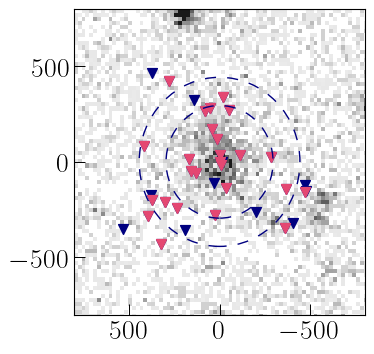

In [9]:
width=4;height=4;ff, ax = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax.pcolormesh(xray_xp_mkpc,xray_yp_mkpc[::-1],xray_image,vmin=0.004, vmax= 10,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')

ax.scatter(kpc_pos_m37[0], kpc_pos_m37[1],s=50, marker='v', c='navy')
ax.scatter(kpc_pos_m26[0], kpc_pos_m26[1],s=50, marker='v', c='#e44872')

ax.set_xlim(-800,800)
ax.set_ylim(-800,800)

circ_500 = plt.Circle((0,0),295,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_500) 

circ_200 = plt.Circle((0,0),443,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_200) 

ax.invert_xaxis()
plt.show()

In [10]:
# can find r500 another way. Need to convert delta pix to delta r:

xlssc_wcs = WCS(xlssc_hdu.header); mem_pos = [mem_RA,mem_DEC]    

# pixel positions of members:

mem_pos_pix = [[] for i in range(len(mem_RA))]
for i in range(len(mem_RA)):
    coord = SkyCoord(mem_RA[i],mem_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    mem_pos_pix[i] = pixels

# can convert to kpc as:
dia_ang = 1759.4 * 1000 # kpc

theta_rad = (5/3) * 10**(-5) * (np.pi/180)

deltaR = theta_rad*dia_ang
    
mem_pos_kpc = (np.array(mem_pos_pix) * deltaR ).T
    
mem_kpc_x = mem_pos_kpc[0] - mem_pos_kpc[0][0]
mem_kpc_y = mem_pos_kpc[1] - mem_pos_kpc[1][0]

    

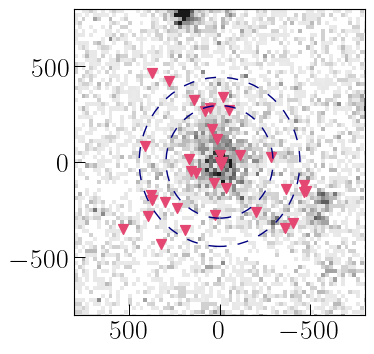

In [11]:
width=4;height=4;ff, ax = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height); ff.tight_layout(pad=1.0)
ax.pcolormesh(xray_xp_mkpc,xray_yp_mkpc[::-1],xray_image,vmin=0.004, vmax= 10,cmap='gray_r', alpha=0.9, zorder=0)#, interpolation='none')

ax.scatter(-mem_kpc_x,mem_kpc_y,s=50, marker='v', c='#e44872')

ax.set_xlim(-800,800)
ax.set_ylim(-800,800)

circ_500 = plt.Circle((0,0),295,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_500) 

circ_200 = plt.Circle((0,0),443,fill = False,color='navy', linestyle=(0,(8,8)), zorder=10)#, label=r'$r_{500}$')
ax.add_patch(circ_200) 

ax.invert_xaxis()
plt.show()

In [12]:
# now we need to find the radial distance from the BCG as in step 5 above:

radial_pos_m26 = [np.sqrt((kpc_pos_m26[0][i]**2 + kpc_pos_m26[1][i]**2)) for i in range(len(kpc_pos_m26[0]))]
radial_pos_m37 = [np.sqrt((kpc_pos_m37[0][i]**2 + kpc_pos_m37[1][i]**2)) for i in range(len(kpc_pos_m37[0]))]

redex_rad_pos = np.array([np.sqrt((redex_pos_kpc[0][i]**2 + redex_pos_kpc[1][i]**2)) for i in range(len(redex_pos_kpc[1]))])

# We can sort this in increasing order: but also need mass to be sorted
mem_ID_m26 = mem_data_m26[0]; mem_ID_m37 = mem_data_m37[0]; 



radial_data_m26 = np.array([mem_ID_m26, radial_pos_m26, mem_data_m26[23]])
radial_data_m37 = np.array([mem_ID_m37, radial_pos_m37, mem_data_m37[23]])

redex_radial_data = np.array([all_red_ID, redex_rad_pos, all_red_mass])

rad_sort_m37= np.array(sorted(radial_data_m37.T, key=itemgetter(1), reverse=False)).T
rad_sort_m26= list(np.array(sorted(radial_data_m26.T, key=itemgetter(1), reverse=False)).T)

redex_rad_sort = np.array(sorted(redex_radial_data.T, key=itemgetter(1), reverse=False)).T

# we now need to generate cumulative mass and number distributions:

cum_mass_m26 = [sum(10**rad_sort_m26[2][0:i]) for i in range(len(mem_ID_m26))] 
cum_mass_m37 = [sum(10**rad_sort_m37[2][0:i]) for i in range(len(mem_ID_m37))]
redex_cum_mass = [sum(10**redex_rad_sort[2][0:i]) for i in range(len(all_red_ID))]

redex_norm_cum = np.array(redex_cum_mass)/ max(redex_cum_mass)



cum_num = np.linspace(0, 50,50)


In [13]:
len(redex_rad_pos)

77

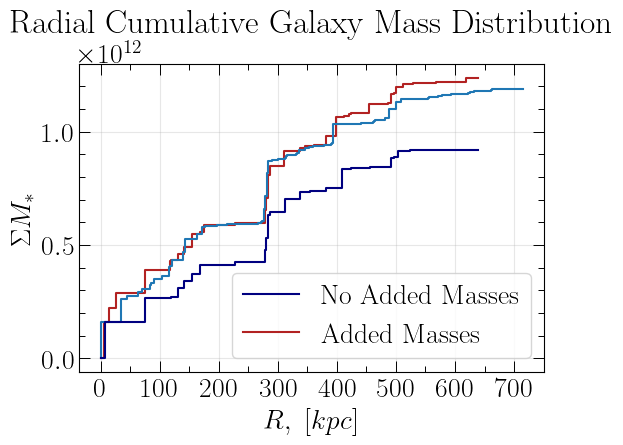

In [14]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25);ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$\Sigma M_{\ast}$")

ax1.step(list(rad_sort_m26[1])+[max(rad_sort_m37[1])],cum_mass_m26+[max(cum_mass_m26)],where='mid', label='No Added Masses', c='navy', zorder=5)
ax1.step(rad_sort_m37[1],np.array(cum_mass_m37), where='mid', label='Added Masses', c='firebrick')
#ax1.plot(rad_sort_m37[1],np.array(cum_mass_m37),c='maroon', alpha=0.3, zorder=0)
#ax1.plot(list(rad_sort_m26[1])+[max(rad_sort_m37[1])],cum_mass_m26+[max(cum_mass_m26)],c='blue', zorder=1, alpha=0.5)

ax1.step(redex_rad_sort[1], redex_cum_mass)

ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

In [15]:
# we want to make a radial density profile from the xray image:

# first need a function to calculate this value:

def radial_profile(data, centre, factor=21.325):
    X,Y = np.indices((data.shape))
    R = np.sqrt((X-centre[0])**2+ (Y-centre[1])**2)
    R = R.astype(int)

    tbin = np.bincount(R.ravel(), data.ravel())
    nr = np.bincount(R.ravel())
    profile = tbin / nr
    radii = factor*np.linspace(0, len(tbin), len(tbin))
    return [radii,profile]

# we can now calculate the radial profile for both the xray and smoothed xray:

# first data:
xray = fits.open(xray_path)[0].data; smooth = fits.open(smooth_path)[0].data

# centre of the BCG IN PIXELS:

centre_bcg = (428,414); centre_bcgs = (120,121)

# profiles:

xray_profile = radial_profile(xray, centre_bcg); smooth_profile = radial_profile(np.nan_to_num(smooth), centre_bcgs)

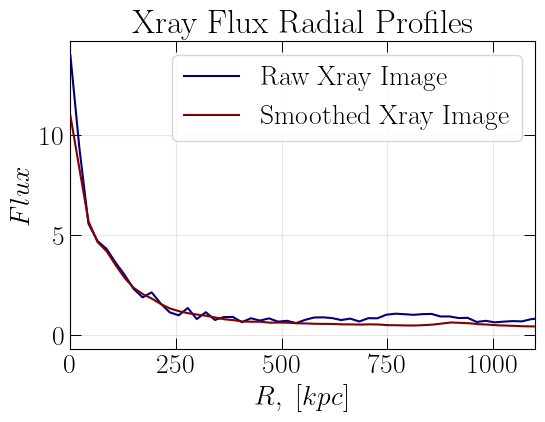

In [16]:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(0,1100);#ax1.set_ylim(-0.2e11, 1.75e11)
ax1.set_title("Xray Flux Radial Profiles")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$Flux$")

ax1.plot(xray_profile[0], xray_profile[1], label='Raw Xray Image', c='navy', zorder=3)
ax1.plot(smooth_profile[0], smooth_profile[1], label='Smoothed Xray Image', c='Maroon', zorder=4)

#ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
#ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend()

plt.show()

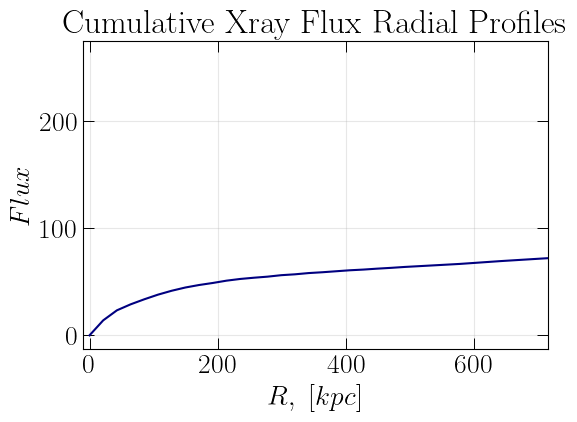

In [17]:
cum_xray = [sum(xray_profile[1][0:i]) for i in range(len(xray_profile[1]))]
cum_smooth = [sum(smooth_profile[1][0:i]) for i in range(len(smooth_profile[1]))]

width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1.set_xlim(-10,715);#ax1.set_ylim(0,1.5)
ax1.set_title("Cumulative Xray Flux Radial Profiles")
ax1.set_xlabel(r"$R, \ [kpc]$")
ax1.set_ylabel(r"$Flux$")

ax1.plot(xray_profile[0], (np.array(cum_xray)), c='navy', zorder=3,)# where='mid')
#ax1.plot(smooth_profile[0], (np.array(cum_smooth)/59), c='maroon', zorder=3)#, where='mid')


#ax1.step(rad_sort_m37[1],np.array(cum_mass_m37)/max(cum_mass_m37), where='mid', c='firebrick')

#ax1.loglog(xray_profile[0], np.array(cum_xray)/66, c='navy', zorder=3)
#ax1.loglog(rad_sort_m37[1],np.array(cum_mass_m37)/max(cum_mass_m37), c='firebrick')


#ax1.yaxis.set_minor_locator(MultipleLocator(1e11));ax1.yaxis.set_major_locator(MultipleLocator(5e11))
#ax1.xaxis.set_minor_locator(MultipleLocator(50));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
#ax1.legend()

plt.show()

In [18]:
# what we want to do now is produce normalized cumulative distributions for all,red,blue etc:

# reminder of our segmented data sets:
red_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) >1.15]).T
blue_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if (mem_data_m26.T[i][3]-mem_data_m26.T[i][4]) <=1.15]).T

red_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) >1.15]).T
blue_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if (mem_data_m37.T[i][3]-mem_data_m37.T[i][4]) <=1.15]).T

old_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]>1.0]).T
young_m26 = np.array([mem_data_m26.T[i] for i in range(len(mem_data_m26.T)) if mem_data_m26.T[i][11]<=1.0]).T

old_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]>1.0]).T
young_m37 = np.array([mem_data_m37.T[i] for i in range(len(mem_data_m37.T)) if mem_data_m37.T[i][11]<=1.0]).T

# just masses:

mass_m26 = mem_data_m26[23]
red_mass_m26 = red_m26[23]; blue_mass_m26 = blue_m26[23]
old_mass_m26 = old_m26[23]; young_mass_m26 = young_m26[23]

mass_m37 = mem_data_m37[23]
red_mass_m37 = red_m37[23]; blue_mass_m37 = blue_m37[23]
old_mass_m37 = old_m37[23]; young_mass_m37 = young_m37[23]

# cumulative mass distributions:
# starting with just m26:

r_data_m26 = np.array([mem_data_m26[0], mem_data_m26[24], mem_data_m26[23]])

r_data_red_m26 = np.array([red_m26[0], red_m26[24], red_m26[23]])
r_data_blue_m26 = np.array([blue_m26[0], blue_m26[24], blue_m26[23]])
r_data_old_m26 = np.array([old_m26[0], old_m26[24], old_m26[23]])
r_data_young_m26 = np.array([young_m26[0], young_m26[24], young_m26[23]])

#r_data_redex_m26 = np.array(faint_reds[16], faint_reds[23], faint_reds[22])


r_sort_m26= list(np.array(sorted(r_data_m26.T, key=itemgetter(1), reverse=False)).T)

r_sort_red_m26= list(np.array(sorted(r_data_red_m26.T, key=itemgetter(1), reverse=False)).T)
r_sort_blue_m26= list(np.array(sorted(r_data_blue_m26.T, key=itemgetter(1), reverse=False)).T)
r_sort_old_m26= list(np.array(sorted(r_data_old_m26.T, key=itemgetter(1), reverse=False)).T)
r_sort_young_m26= list(np.array(sorted(r_data_young_m26.T, key=itemgetter(1), reverse=False)).T)


# we now need to generate cumulative mass and number distributions:

cume_mass_m26 = [sum(10**r_sort_m26[2][0:i]) for i in range(len(mem_ID_m26))] 
cume_mass_red_m26 = [sum(10**r_sort_red_m26[2][0:i]) for i in range(len(red_m26[0]))] 
cume_mass_blue_m26 = [sum(10**r_sort_blue_m26[2][0:i]) for i in range(len(blue_m26[0]))] 
cume_mass_old_m26 = [sum(10**r_sort_old_m26[2][0:i]) for i in range(len(old_m26[0]))] 
cume_mass_young_m26 = [sum(10**r_sort_young_m26[2][0:i]) for i in range(len(young_m26[0]))] 

cume_norm_m26 = np.array([sum(10**r_sort_m26[2][0:i]) for i in range(len(mem_ID_m26))])/max(cume_mass_m26) 
cume_norm_red_m26 = np.array([sum(10**r_sort_red_m26[2][0:i]) for i in range(len(red_m26[0]))] )/max(cume_mass_red_m26)
cume_norm_blue_m26 = np.array([sum(10**r_sort_blue_m26[2][0:i]) for i in range(len(blue_m26[0]))] )/max(cume_mass_blue_m26)
cume_norm_old_m26 = np.array([sum(10**r_sort_old_m26[2][0:i]) for i in range(len(old_m26[0]))] )/max(cume_mass_old_m26)
cume_norm_young_m26 = np.array([sum(10**r_sort_young_m26[2][0:i]) for i in range(len(young_m26[0]))])/ max(cume_mass_young_m26)
cum_num = np.linspace(0, 50,50)

In [19]:
colours2[0]

'#006483'

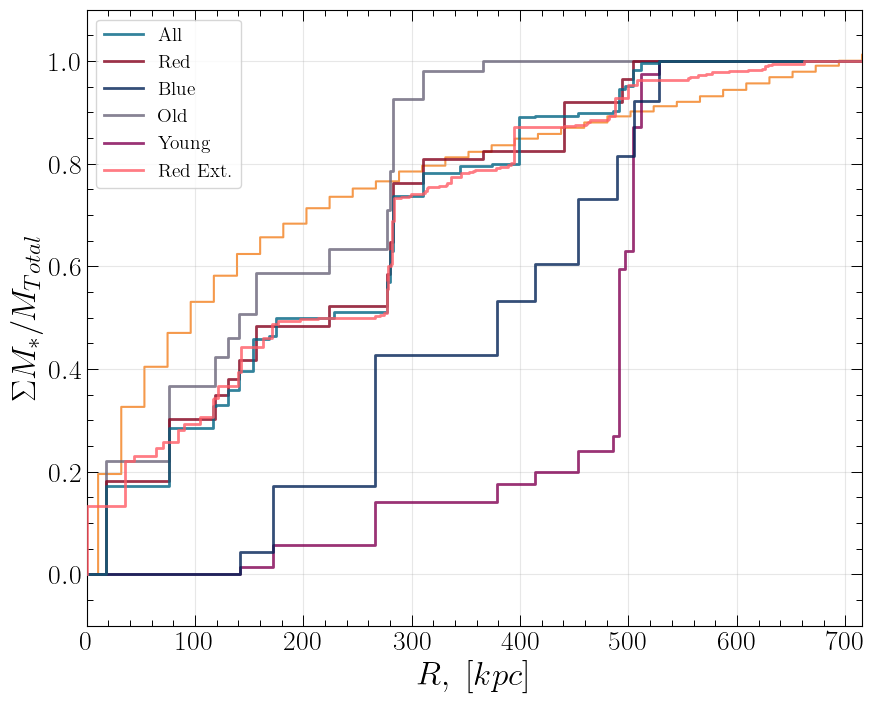

In [25]:
width=10;height=8;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

#ax1.set_xlim(20,25);ax1.set_ylim(-0.2e11, 1.75e11)
#ax1.set_title("Radial Cumulative Galaxy Mass Distribution")
ax1.set_xlabel(r"$R, \ [kpc]$", fontsize=24)
ax1.set_ylabel(r"$\Sigma M_{\ast}/M_{Total}$",fontsize=24)

ax1.step([0]+list(r_sort_m26[1])+[max(redex_rad_sort[1])],[0]+list(cume_mass_m26/max(cume_mass_m26))+[1],where='mid', label='All', c=colours2[0], zorder=10, linewidth=2,alpha=0.8)
ax1.step([0]+list(r_sort_red_m26[1])+[max(redex_rad_sort[1])],[0]+list(cume_mass_red_m26/max(cume_mass_red_m26))+[1],where='mid', label='Red', c=colours2[1], zorder=7, linewidth=2,alpha=0.8)
ax1.step([0]+list(r_sort_blue_m26[1])+[max(redex_rad_sort[1])],[0]+list(cume_mass_blue_m26/max(cume_mass_blue_m26))+[1],where='mid', label='Blue', c=colours2[2], zorder=6, linewidth=2,alpha=0.8)
ax1.step([0]+list(r_sort_old_m26[1])+[max(redex_rad_sort[1])],[0]+list(cume_mass_old_m26/max(cume_mass_old_m26))+[1],where='mid', label='Old', c=colours2[3], zorder=3, linewidth=2,alpha=0.8)
ax1.step([0]+list(r_sort_young_m26[1])+[max(redex_rad_sort[1])],[0]+list(cume_mass_young_m26/max(cume_mass_young_m26))+[1],where='mid', label='Young', c=colours2[4], zorder=5, linewidth=2,alpha=0.8)

ax1.step([0]+redex_rad_sort[1], redex_norm_cum, where='pre', c=colours2[5], linewidth=2, zorder=15, alpha=0.8, label="Red Ext.")

#ax1.step(xray_profile[0], (np.array(cum_xray)/(np.array(cum_xray)[34]-0.92)), c='peru', zorder=0, where='mid', alpha=0.5)

ax1.step(xray_profile[0], (np.array(cum_xray)/(np.array(cum_xray)[34]-0.92)), c='#f5994b', zorder=0, where='mid', alpha=1)


ax1.yaxis.set_minor_locator(MultipleLocator(0.05));ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(20));ax1.xaxis.set_major_locator(MultipleLocator(100))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)
ax1.legend(fontsize=14)
ax1.set_xlim(0,715)
ax1.set_ylim(-0.1,1.1)


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/4_radial_mass_dists", dpi=250)


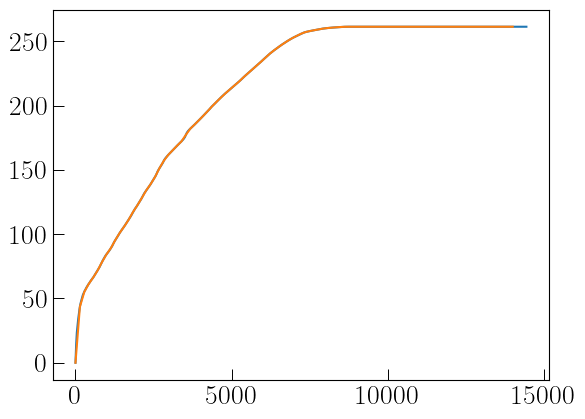

In [22]:
# going to try and create a sample distribution that we can draw on:

from scipy.interpolate import interp1d


xray_distribution = interp1d(xray_profile[0], np.array(cum_xray))


ben = np.linspace(0, 14000, 100)

plt.plot(xray_profile[0], np.array(cum_xray))
plt.plot(ben, xray_distribution(ben))

In [23]:
xray_dist

NameError: name 'xray_dist' is not defined

In [24]:
print(max(r_sort_m26[1]))
print(max(r_sort_red_m26[1]))
print(max(r_sort_blue_m26[1]))
print(max(r_sort_old_m26[1]))
print(max(r_sort_young_m26[1]))
print(max(redex_rad_sort[1]))

540.1171659
508.0252754
540.1171659
394.0287277
540.1171659
715.6277970877627


In [25]:
xray_dist[:20]

NameError: name 'xray_dist' is not defined

In [26]:
# now we can perform the KS test for all sub samples with the smooth and raw xray profiles:

# first need to generate distribution that is normalized and the length of the region:

indx = 35;xray_max = cum_xray[indx]; smooth_max = cum_smooth[indx]; 

xray_dist = xray_profile[0][:indx+1]; cume_xray = cum_xray[:indx+1]/xray_max
smooth_dist = smooth_profile[0][:indx]; cume_smooth = cum_smooth[:indx]/smooth_max

# can now KS test with our xray distribution:



ks_m26_all = sp.stats.ks_2samp(r_sort_m26[1],xray_dist[:25])
ks_m26_red = sp.stats.ks_2samp(r_sort_red_m26[1],xray_dist[:24])
ks_m26_blue = sp.stats.ks_2samp(r_sort_blue_m26[1],xray_dist[:24])
ks_m26_old = sp.stats.ks_2samp(r_sort_old_m26[1],xray_dist[:19])
ks_m26_young = sp.stats.ks_2samp(r_sort_young_m26[1],xray_dist[:25])
ks_m26_redex = sp.stats.ks_2samp(redex_rad_sort[1], xray_dist[:34])

ks_m26 = np.array([ks_m26_all,ks_m26_red,ks_m26_blue,ks_m26_old,ks_m26_young, ks_m26_redex]).T



smooth_ks_m26_all = sp.stats.ks_2samp(r_sort_m26[1],smooth_dist)
smooth_ks_m26_red = sp.stats.kstest(r_sort_red_m26[1],smooth_dist)
smooth_ks_m26_blue = sp.stats.kstest(r_sort_blue_m26[1],smooth_dist)
smooth_ks_m26_old = sp.stats.kstest(r_sort_old_m26[1],smooth_dist)
smooth_ks_m26_young = sp.stats.kstest(r_sort_young_m26[1],smooth_dist)
smooth_ks_m26_redex = sp.stats.kstest(redex_rad_sort[1],smooth_dist)


smooth_ks_m26 = np.array([smooth_ks_m26_all,smooth_ks_m26_red,smooth_ks_m26_blue,smooth_ks_m26_old,smooth_ks_m26_young,smooth_ks_m26_redex]).T

In [48]:
ks_m26

array([[0.18923077, 0.14583333, 0.40833333, 0.16194332, 0.45846154,
        0.13559969],
       [0.63965128, 0.9754277 , 0.14278159, 0.95924231, 0.03138017,
        0.71655642]])

In [46]:
def c(alp, n, m, i):
    nn = 2*len(n)
    mm = 2*len(m)
    D = ks_m26[0][i]
    c = np.sqrt(-np.log(alp/2)*0.5)
    cond = c*np.sqrt((nn+mm)/(nn*mm))
    cond2 = np.sqrt(-np.log(alp/2) *((1+mm/nn)/(2*mm)))
    if cond2 < D:
        print('yay')
    elif cond2 >= D:
        print('oh no')
    return [D, cond]

In [47]:
print(c(0.05, r_sort_m26[1],xray_dist[:25], 0))
print(c(0.05, r_sort_red_m26[1],xray_dist[:24], 1))
print(c(0.05, r_sort_blue_m26[1],xray_dist[:24], 2))
print(c(0.05, r_sort_old_m26[1],xray_dist[:19], 3))
print(c(0.05, r_sort_young_m26[1],xray_dist[:25], 4))
print(c(0.05, redex_rad_sort[1], xray_dist[:34], 5))

oh no
[0.18923076923076923, 0.26899589084637504]
oh no
[0.14583333333333334, 0.3099428481471228]
yay
[0.4083333333333333, 0.361452367539443]
oh no
[0.16194331983805668, 0.3456557204160258]
yay
[0.4584615384615385, 0.3283729343952246]
oh no
[0.13559969442322384, 0.19773971522614386]


In [28]:
ks_m26

array([[0.18923077, 0.14583333, 0.40833333, 0.16194332, 0.45846154,
        0.13559969],
       [0.63965128, 0.9754277 , 0.14278159, 0.95924231, 0.03138017,
        0.71655642]])

In [27]:
sp.stats.ks_2samp(r_sort_m26[1],xray_profile[1])


KstestResult(statistic=0.9615384615384616, pvalue=6.087931404609892e-33, statistic_location=14.0, statistic_sign=-1)

In [357]:
sp.stats.kstest(r_sort_m26[1],xray_dist)


KstestResult(statistic=0.2777777777777778, pvalue=0.15624620215021667, statistic_location=540.1171659, statistic_sign=1)

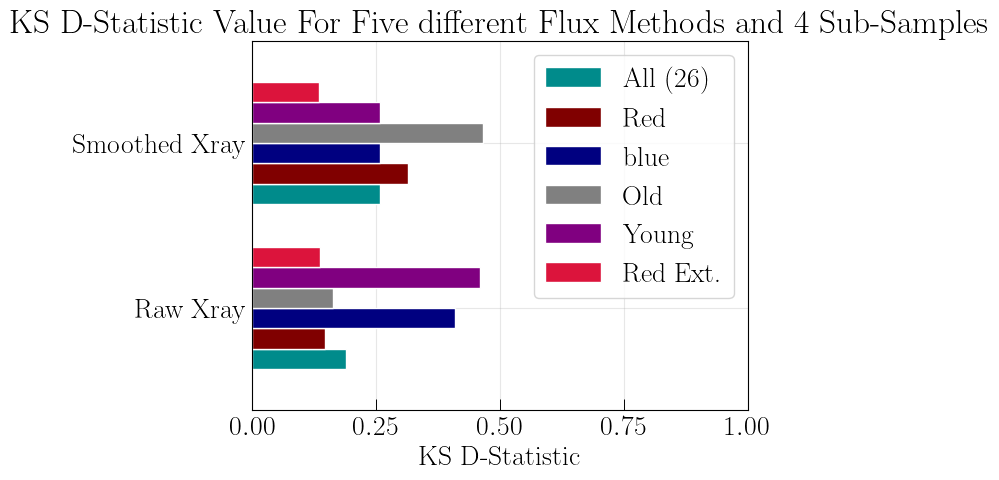

In [358]:
# we now wish to plot the found values in a concise manner: will use pandas:
import pandas as pd

rdata = pd.DataFrame({
    "All (26)":[ks_m26[0][0],smooth_ks_m26[0][0]],
    
    "Red":[ks_m26[0][1],smooth_ks_m26[0][1]],
    "blue":[ks_m26[0][2],smooth_ks_m26[0][2]],
    "Old":[ks_m26[0][3],smooth_ks_m26[0][3]],
    "Young":[ks_m26[0][4],smooth_ks_m26[0][4]],
    "Red Ext.":[ks_m26[0][5],smooth_ks_m26[0][5]]
    }, 
    index=["Raw Xray", "Smoothed Xray"]
)
rdata.plot(kind="barh", color=['darkcyan', 'maroon', 'navy','gray', 'purple', 'crimson'], edgecolor='white', zorder=2, width=0.74)

plt.title("KS D-Statistic Value For Five different Flux Methods and 4 Sub-Samples")
plt.xlabel("KS D-Statistic")
#plt.ylabel("Method")
plt.xlim(-0.001,1)
plt.grid(alpha=0.3,zorder=0)
plt.show()


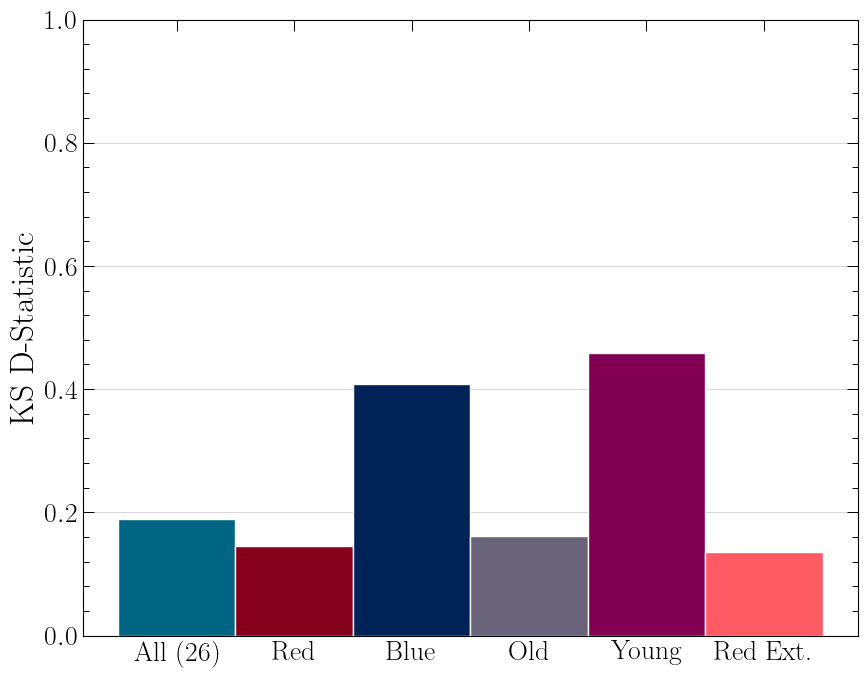

In [363]:
import pandas as pd

names = ['All (26)', 'Red', 'Blue', 'Old', 'Young' , 'Red Ext.']

#rdata.plot(kind="bar", color=colours2, edgecolor='white', zorder=2, width=0.74)



width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, ks_m26[0], color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("KS D-Statistic", fontsize=24)
#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
#ax1.set_yscale('log')
ax1.xaxis.grid(False)
ax1.set_ylim(0,1)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])


plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/4_ks_d_stat_6samps", dpi=250)


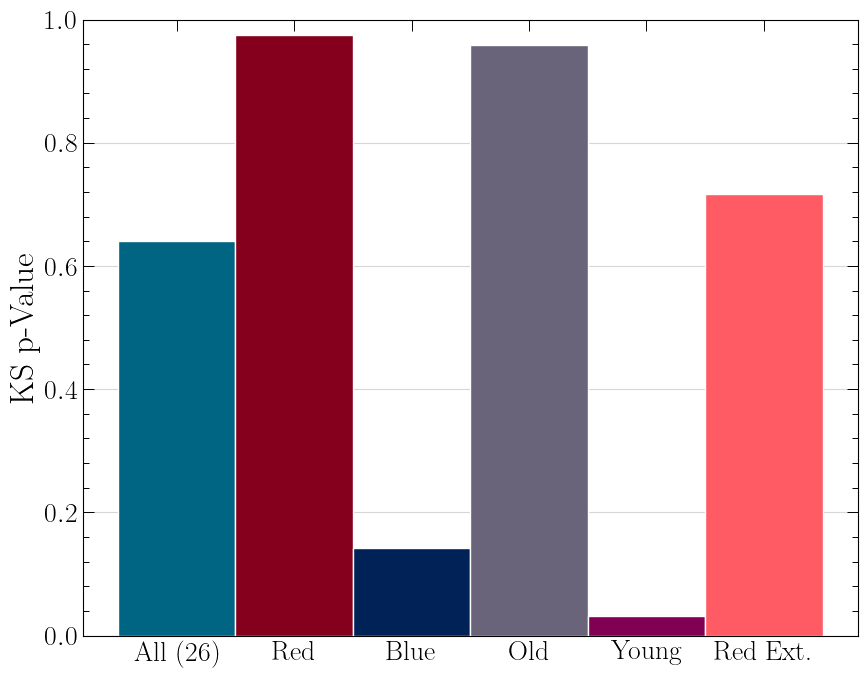

In [364]:
width=10;height=8;ff, ax1 = plt.subplots(1,1, sharex=True, sharey=True);ff.set_figwidth(width);ff.set_figheight(height)

ax1.bar(names, ks_m26[1], color=colours2, edgecolor='white', zorder=2, width=1, linewidth=1)

#plt.title("Pearson-r Value For Five different Flux Methods and 4 Sub-Samples")



ax1.set_ylabel("KS p-Value", fontsize=24)
#plt.ylabel("Method")
#ax1.set_xlim(-0.6,0.6)

#ax1.xaxis.set_major_locator(MultipleLocator(1/6))
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.04))
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
#ax1.tick_params(axis='both', direction="in")
#ax1.tick_params(which="minor", axis="x", direction="in")
#ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid('y', alpha=0.5, zorder=10)
#ax1.set_yscale('log')
ax1.xaxis.grid(False)
ax1.set_ylim(0,1)

#shifted_positions = np.arange(len(df['Category'])) + 1
#ax1.set_xticks(shifted_positions)
#ax1.set_xticklabels(df['Category'])

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/4_ks_p_value_6samps", dpi=250)


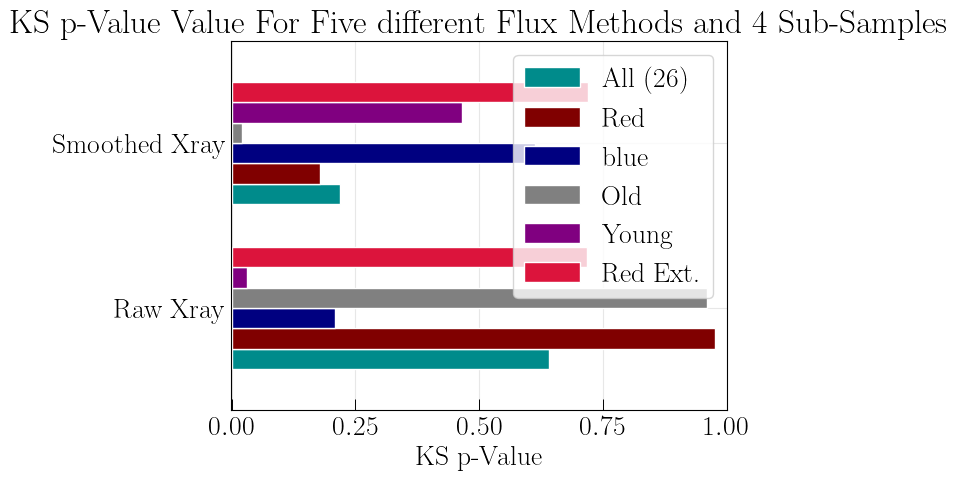

In [352]:
# we now wish to plot the found values in a concise manner: will use pandas:
import pandas as pd

rdata = pd.DataFrame({
    "All (26)":[ks_m26[1][0],smooth_ks_m26[1][0]],
    
    "Red":[ks_m26[1][1],smooth_ks_m26[1][1]],
    "blue":[ks_m26[1][2],smooth_ks_m26[1][2]],
    "Old":[ks_m26[1][3],smooth_ks_m26[1][3]],
    "Young":[ks_m26[1][4],smooth_ks_m26[1][4]],
    "Red Ext.":[ks_m26[1][5],smooth_ks_m26[1][5]],

    }, 
    index=["Raw Xray", "Smoothed Xray"]
)
rdata.plot(kind="barh", color=['darkcyan', 'maroon', 'navy','gray', 'purple', 'crimson'], edgecolor='white', zorder=2, width=0.74)

plt.title("KS p-Value Value For Five different Flux Methods and 4 Sub-Samples")
plt.xlabel("KS p-Value")
#plt.ylabel("Method")
plt.xlim(-0.001,1)
plt.grid(alpha=0.3,zorder=0)
plt.show()
